# Experimento mestrado 2 - Ex 1
## Executando na pasta principal

In [1]:
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
os.chdir('../../../../') #Executando na pasta Visual_Memory
import sys
sys.path.append('./include')
sys.path.append('./src')

### Criando lista de videos 

In [2]:
address = "/home/fei/Videos/Ex1"
Files = os.listdir(address)
Files.sort()

In [3]:
filesrob = []
filescel = []
for video in Files:
    if video.find('cel') == -1:
        filesrob.append(video)
    else:
        filescel.append(video)

Files = zip(filesrob, filescel)

### Preparando sistema:

In [4]:
# Files = Files[:2]
# print Files

In [5]:
# os.system("mkdir Ex1")
# listTime = []
# for vision, debug in Files:
#     # Criando sh da visão
#     text = open("./runvision.sh", "w")
#     text.write("#!/bin/bash\nPYTHONPATH=~/models/research/slim:~/models/research/object_detection:~/models/research:$PYTHONPATH\n\ncd Vision/\npython vision.py --dnn --v " + address + "/" + vision)
#     text.close()
#     os.system("chmod 755 runvision.sh")
    
#     # Criando sh da Visual Memory
#     text = open("./runvisualmemory.sh", "w")
#     text.write("#!/bin/bash\n\ncd Visual_Memory/\npython visualMemory.py --d --sd --nr 3 --p 333")
#     text.close()
#     os.system("chmod 755 runvisualmemory.sh")

#     # Limpando bkb
#     os.system("screen -d -m -S 'Vision' './runvision.sh'")
#     time.sleep(3)
#     os.system("kill $(pidof -x ./runvision.sh)")
    
#     #Executando Visual Memory
#     os.system("screen -d -m -S 'VisualMemory' './runvisualmemory.sh'")
#     os.system("gnome-terminal -x sh -c 'screen -R VisualMemory'")
    
#     #Executando visão[tempo, x, y, vx, vy, ex, ey, evx, evy, cx, cy, cvx, cvy, time]
#     os.system("screen -d -m -S 'Vision' './runvision.sh'")
# #     os.system("gnome-terminal -x sh -c 'screen -R Vision'")
    
#     #Vendo video
# #     os.system("gnome-terminal -x sh -c 'sleep 4 && vlc " + address + "/" + debug + "'")
    
#     listTime.append([vision.split("_")[0], time.time()])
    
#     while os.system("pidof -x ./runvision.sh") == 0:
#         time.sleep(1)
    
#     os.system("kill $(pidof -x ./runvisualmemory.sh)")
#     os.system("kill $(pidof -x ./runvision.sh)")
#     os.system("kill $(pidof -x vlc)")
    
#     os.system("mv ./Visual_Memory/Data/Thread-1-Robots.npy ./Ex1/" + vision.split("_")[0] + ".npy")
    
#     os.system("sleep 5")

# text = open("./time.txt", "w")
# text.write(str(listTime))
# text.close()
# raw_input("Esperando..")

Esperando..


''

In [6]:
address = "./Ex1"
Files = os.listdir(address)
Files.sort()
listData = []
for name in Files:
#     print address + "/" + name
    dataRob = np.load(address + "/" + name)
    dataExp = []
    for tempo, [x, y, vx, vy], [ex, ey, evx, evy], [cx, cy, cvx, cvy], t in dataRob:
        dataExp.append([tempo, x, y, vx, vy, ex, ey, evx, evy, cx, cy, cvx, cvy, t])
    dataExp = pd.DataFrame(
        dataExp,
        columns=[
            "Tempo",
            "Posição X",
            "Posição Y",
            "Velocidade X",
            "Velocidade Y",
            "Erro PX",
            "Erro PY",
            "Erro VX",
            "Erro VY",
            "Covariância PX",
            "Covariância PY",
            "Covariância VX",
            "Covariância VY",
            "Time",
        ]
    )
#     dataExp["Tempo"] = dataExp["Tempo"] - dataExp["Tempo"][0]
    listData.append(dataExp)

In [7]:
listTime = pd.DataFrame(
    np.loadtxt("time.txt")[:,1],
    index = [str(int(i)) for i in np.loadtxt("time.txt")[:,0]]
)
for data, time in zip(listData, listTime[0]):
    data["Tempo"] = data["Tempo"] - time

In [8]:
listData[0]

,Tempo,Posição X,Posição Y,Velocidade X,Velocidade Y,Erro PX,Erro PY,Erro VX,Erro VY,Covariância PX,Covariância PY,Covariância VX,Covariância VY,Time
0,9.184632,147.150517,-99.467528,0.000000,0.000000,36.9327363910202,36.9327363910202,50,50,36.932736,0.0,24.426150,0.0,-1
1,9.491205,147.150517,-99.467528,0.000000,0.000000,56.6088951013427,56.6088951013427,50,50,56.608895,0.0,39.754808,0.0,-1
2,9.824545,147.150517,-99.467528,0.000000,0.000000,88.6684002984566,88.6684002984566,50,50,88.668400,0.0,56.421804,0.0,-1
3,10.157661,147.150517,-99.467528,0.000000,0.000000,131.806733349561,131.806733349561,50,50,131.806733,0.0,73.077607,0.0,-1
4,10.490990,147.150517,-99.467528,0.000000,0.000000,186.079909130220,186.079909130220,50,50,186.079909,0.0,89.744055,0.0,-1
5,10.824389,147.150517,-99.467528,0.000000,0.000000,251.478822570800,251.478822570800,50,50,251.478823,0.0,106.414008,0.0,-1
6,11.157663,147.150517,-99.467528,0.000000,0.000000,327.962417163246,327.962417163246,50,50,327.962417,0.0,123.077703,0.0,-1
7,11.491198,147.150517,-99.467528,0.000000,0.000000,415.626127691601,415.626127691601,50,50,415.626128,0.0,139.754450,0.0,-1
8,11.824374,147.150517,-99.467528,0.000000,0.000000,514.302140070507,514.302140070507,50,50,514.302140,0.0,156.413257,0.0,-1
9,12.157814,147.150517,-99.467528,0.000000,0.000000,624.170147294035,624.170147294035,50,50,624.170147,0.0,173.085260,0.0,-1


In [9]:
interposy = listData[0]["Posição Y"].values
interposy

listData[0]["Erro PY"] = listData[0]["Erro PY"].values.astype(float)
intererry = listData[0]["Erro PY"].values
intererry

vel = ((600/max(listData[0]["Tempo"]))*listData[0]["Tempo"] - 300).values

for data in listData[1:]:
    newposy = np.interp(
        listData[0]["Tempo"],
        data["Tempo"],
        data["Posição Y"]
    )
    
    data["Erro PY"] = data["Erro PY"].values.astype(float)
    newerry = np.interp(
        listData[0]["Tempo"],
        data["Tempo"],
        data["Erro PY"]
    )
    
    b = np.interp(
        listData[0]["Tempo"],
        data["Tempo"],
        ((600/max(data["Tempo"]))*data["Tempo"] - 300).values
    )
    
    try:
        interposy = np.append(interposy, [newposy], axis=0)
        intererry = np.append(intererry, [newerry], axis=0)
        vel = np.append(vel, [b], axis=0)
    except ValueError:
        interposy = np.append([interposy], [newposy], axis=0)
        intererry = np.append([intererry], [newerry], axis=0)
        vel = np.append([vel], [b], axis=0)

In [10]:
# zip(interposy.mean(axis=0), np.sqrt(interposy.var(axis=0)))
# zip(intererry.mean(axis=0), np.sqrt(intererry.var(axis=0)))
# zip(vel.mean(axis=0), np.sqrt(vel.var(axis=0)))

In [11]:
t = max(listData[0]["Tempo"])
# t = 0
print "Conta x:", (600/max(listData[0]["Tempo"]))*t - 300, "cm\nVelocidade:", (600/max(listData[0]["Tempo"])), "cm/s"

Conta x: 300.0 cm
Velocidade: 12.3743044291 cm/s


In [12]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [13]:
os.system("mkdir /home/fei/Imagens/")
os.system("sleep 3")

0

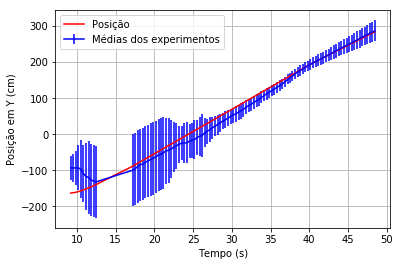

In [14]:
limit = 100

# plt.figure(figsize = (12,8))
plt.plot(
    listData[0]["Tempo"], # Tempo
    vel.mean(axis = 0), # Desejado
    "r", # Cor e padrão
    label = u"Posição",
)

plt.errorbar(
    listData[0]["Tempo"], # Tempo
    interposy.mean(axis = 0), # Posição
    yerr = np.clip(intererry.mean(axis = 0), -limit, limit), # Erro Y
    color = "b", # Cor e padrão
    label = u"Médias dos experimentos",
)

plt.legend(loc = 2)
plt.xlabel(u"Tempo (s)")
plt.ylabel(u"Posição em Y (cm)")
# plt.title(u"Distância do rôbo em Y pelo tempo")

plt.grid()
plt.savefig("/home/fei/Imagens/ex1graf1.png", dpi = 720)

In [15]:
for data, time in zip(listData, listTime[0]):
    data["Posição Y"] = abs((600/max(data["Tempo"]))*data["Tempo"] - 300 - data["Posição Y"])

In [16]:
interposy = listData[0]["Posição Y"].values
interposy

listData[0]["Erro PY"] = listData[0]["Erro PY"].values.astype(float)
intererry = listData[0]["Erro PY"].values
intererry

vel = ((600/max(listData[0]["Tempo"]))*listData[0]["Tempo"] - 300).values

for data in listData[1:]:
    newposy = np.interp(
        listData[0]["Tempo"],
        data["Tempo"],
        data["Posição Y"]
    )
    
    data["Erro PY"] = data["Erro PY"].values.astype(float)
    newerry = np.interp(
        listData[0]["Tempo"],
        data["Tempo"],
        data["Erro PY"]
    )
    
    b = np.interp(
        listData[0]["Tempo"],
        data["Tempo"],
        ((600/max(data["Tempo"]))*data["Tempo"] - 300).values
    )
    
    try:
        interposy = np.append(interposy, [newposy], axis=0)
        intererry = np.append(intererry, [newerry], axis=0)
        vel = np.append(vel, [b], axis=0)
    except ValueError:
        interposy = np.append([interposy], [newposy], axis=0)
        intererry = np.append([intererry], [newerry], axis=0)
        vel = np.append([vel], [b], axis=0)

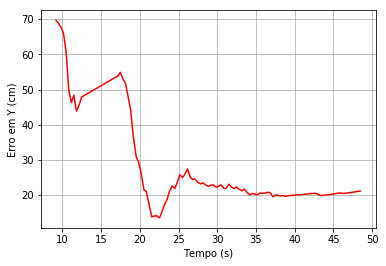

In [17]:
# plt.figure(figsize=(12,8))
plt.plot(
    listData[0]["Tempo"], # Tempo
    interposy.mean(axis = 0), # Desejado
    "r", # Cor e padrão
    label = u"Erro Y",
)

# plt.axhline(
#     interposy.mean( ),
#     color = 'b',
#     linestyle = '--',
#     label = u"Média",
# )

# plt.legend(loc = 2)
plt.xlabel(u"Tempo (s)")
plt.ylabel(u"Erro em Y (cm)")
# plt.title(u"Erro de distância em Y pelo tempo")

plt.grid()
plt.savefig("/home/fei/Imagens/ex1graf2.png", dpi = 720)

In [18]:
interposy = interposy.mean(axis=0)

In [19]:
print interposy.mean(), "±", np.sqrt(interposy.var( )), "cm"

26.595227250694542 ± 12.86588067116116 cm


In [20]:
os.system("mkdir /home/fei/Dados/")
os.system("sleep 3")

with open("/home/fei/Dados/media.txt", "w") as f:
    f.write(str(round(interposy.mean( ), 2)))

with open("/home/fei/Dados/desvio.txt", "w") as f:
    f.write(str(round(np.sqrt(interposy.var( )), 2)))